In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import powerlaw
import pickle
import community
from importlib import reload 
reload(community)
import random
from bokeh.io import output_notebook, show
from bokeh.models import Range1d, Circle, MultiLine, NodesAndLinkedEdges
from bokeh.plotting import from_networkx
import bokeh.plotting.figure as bokeh_figure
from IPython.display import Markdown as md
import collections



#from IPython.display import display
#from IPython.core.display import display as disp, HTML
#from ipywidgets import widgets, interact, interactive, fixed, interact_manual
#from IPython.display import Image

# The Star Wars network

## Visulization of the network

In this part we will visualize the network based on different factors using the GCC graph. In all the plots the node size is based on the degree of the node. In the first plot we wish to color the nodes based on the _Alliance_ for a character, thus we have created a function `map_color` which will be able generate the corresponding color based on _Alliance_. We have defined the colors as:  
| _Alliance_ | Color  |
|------------|--------|
| Good       | Green  |
| Evil       | Purple |
| Jedi       | Blue   |
| Sith       | Red    |
| Mix        | Orange |
| Unknown    | Pink   |

In [2]:
# Load the character dataframe 
characters_df = pd.read_csv('data/characters.csv')

# Load the network 
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)
with open('data/SW_DG_GCC.gpickle', 'rb') as handle:
    SW_DG_GCC = pickle.load(handle)

# Create to undirected graph for plot
G_SW_GCC = SW_DG_GCC.to_undirected()

# Load the partition 
with open('data/partition.pickle', 'rb') as handle:
    partition = pickle.load(handle)


We start with creating a simple visulization to get an quick glanse at the graph.

In [3]:
def map_color(x):
    if x == 'Good':
        return 'green'
    elif x == 'Jedi':
        return 'blue'
    elif x == 'Sith':
        return 'red'
    elif x == 'Evil':
        return 'purple'
    elif x == 'Mix':
        return 'darkorange'
    else: 
        return 'pink'

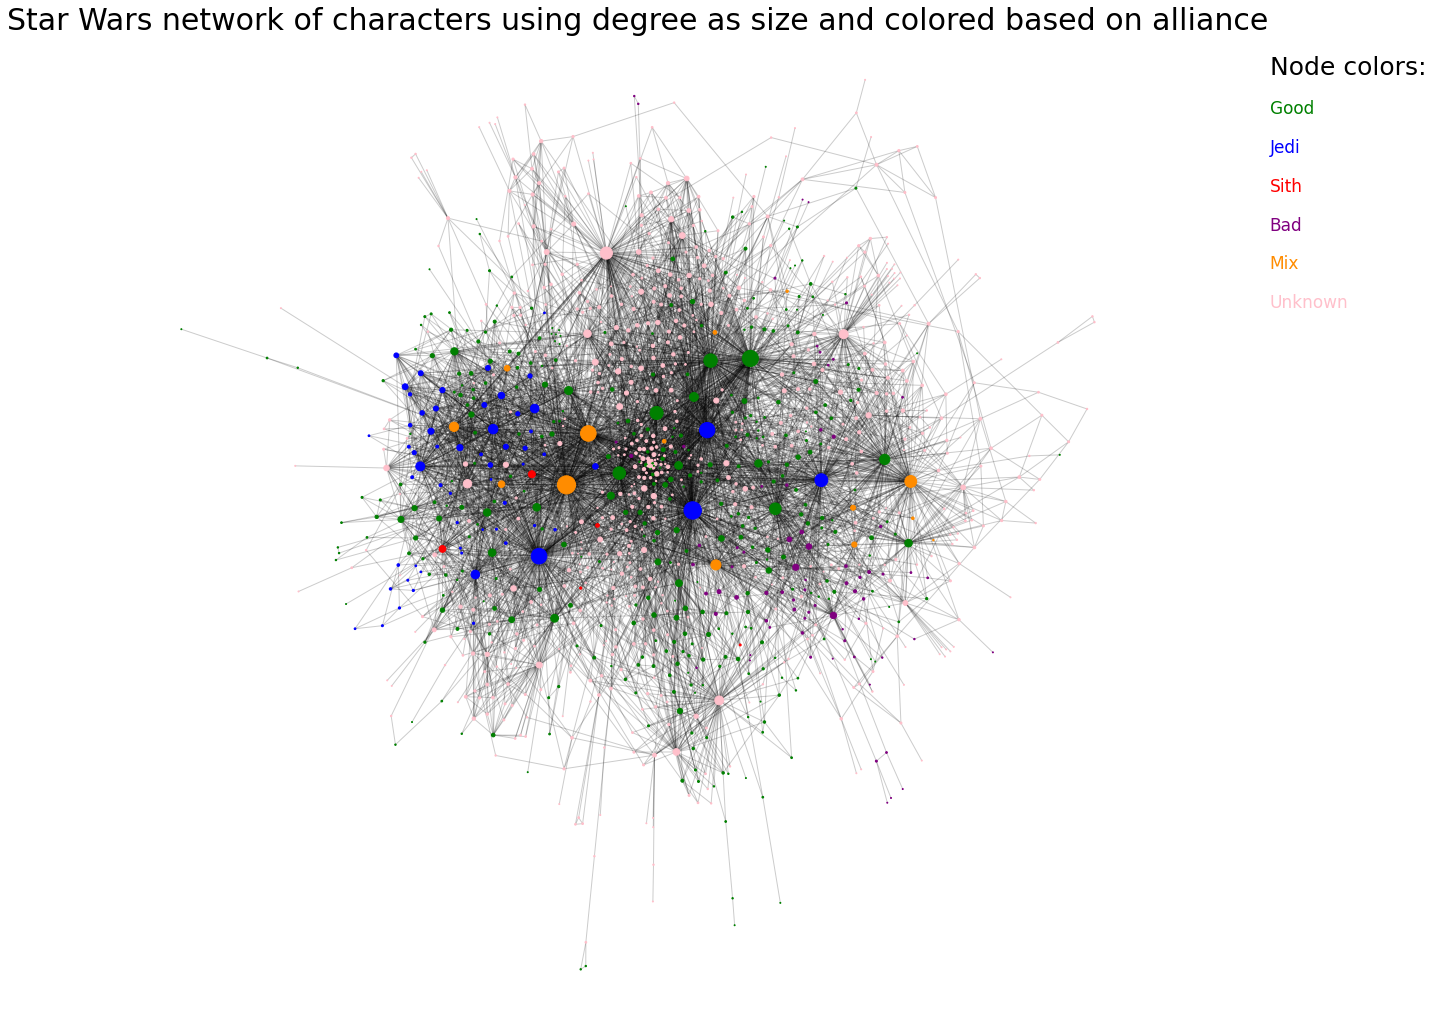

In [4]:
## Visulization based on Alliance and degree
# Setting node size based on degree
node_size = [val for (_, val) in G_SW_GCC.degree()]

# Compute the color for each nodes 
colors = [map_color(G_SW_GCC.nodes[n]['Alliance']) for n in G_SW_GCC.nodes()]

# Load position
with open('data/positions_still.pickle', 'rb') as handle:
    positions_still = pickle.load(handle)

# Plotting the graph
plt.figure(figsize = [18, 18])
nx.draw_networkx_nodes(G_SW_GCC, positions_still, node_size=node_size, node_color = colors, alpha=1)
nx.draw_networkx_edges(G_SW_GCC, positions_still, alpha=0.2, arrows=False)
plt.axis('off')

# Indicating node colors
y = 0.85 # This is the starting y position for the figure legend
plt.figtext(1, y, 'Node colors:', size = 25, color = 'black')
color_node = ['green','blue','red', 'purple', 'darkorange', 'pink']
role_node = ['Good', 'Jedi', 'Sith', 'Bad', 'Mix', 'Unknown']
y -= 0.03
for i in range(len(color_node)):
    plt.figtext(1, y, str(role_node[i]), size = 17, color = color_node[i])
    y -= 0.03

plt.title("Star Wars network of characters using degree as size and colored based on alliance", fontsize=30)
plt.show()

We see that there are a lot of nodes and there are not many evil and Sith characters. To get a better understanding we will create an interactive graph.  
Create a new postion with changed weight for the variables.

The interactive graph will again be color based on the _alliance_ and the size is based on the degree. In contrast to the first plot, we will scale the node size such we can see a more significant difference between nodes. Furthermore, we have added some of the attributes to the interactive graph.

In [5]:
from matplotlib import colors
output_notebook()

## adding degree as an attribute
degrees = dict(nx.degree(G_SW_GCC))
nx.set_node_attributes(G_SW_GCC, name='degree', values=degrees)

## Adjusting the node size to be based on the degree 
number_to_adjust_by = 2
adjusted_node_size = dict([(node, degree*0.17 + number_to_adjust_by) for node, degree in nx.degree(G_SW_GCC)])
nx.set_node_attributes(G_SW_GCC, name='adjusted_node_size', values=adjusted_node_size)

Alliance_colors = dict([(n, map_color(G_SW_GCC.nodes[n]['Alliance'])) for n in G_SW_GCC.nodes()])
nx.set_node_attributes(G_SW_GCC, name='Alliance_colors', values=Alliance_colors)

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from network to size and color by
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'Alliance_colors'

#Choose a title
title = 'Star Wars interactive Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
    ("Character", "@index"),
        ('Species', '@Species'),
        ('Gender', '@Gender'),
        ('Alliance', '@Alliance'),
        ('Homeworld', '@Homeworld'),
        ('Apperance', '@Appearance'),
        ("Degree", "@degree")
]

#Create a plot — set dimensions, toolbar, and title
plot = bokeh_figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-20.1, 20.1), y_range=Range1d(-20.1, 20.1), title=title)


#Load the position created with Fa2
with open('data/positions_inter_z.pickle', 'rb') as handle:
    positions_inter_z = pickle.load(handle)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_SW_GCC, positions_inter_z, scale=1, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)

#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.1, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)
show(plot)


Loading BokehJS ...

We can see that the main characters for movies are the ones with the largest node size. We see none of the larger nodes are categorized as evil or Sith, this also correspond with the bad guys in the movies are mainly without names. We see the largest node is _Anakin Skywalker_ (Darth Vader) and he is categorized as mix, which is corrected due to the transformation in the prequals, he turns from the light side to the dark side. _Darth Sidious_ is also categorized as mix, this is not completely correct. He is the evil all through the movies, but due to him pretending to be good.

We will now look at the communities for our GCC network. We will talk more about the communities in Part 5 Community Analysis. Here we will simply create the communties and take a look at the plot for it. 

In [6]:
from matplotlib import colors
output_notebook()

## adding degree as an attribute
degrees = dict(nx.degree(G_SW_GCC))
nx.set_node_attributes(G_SW_GCC, name='degree', values=degrees)

## Adjusting the node size to be based on the degree 
number_to_adjust_by = 0
adjusted_node_size = dict([(node, degree + number_to_adjust_by) for node, degree in nx.degree(G_SW_GCC)])
nx.set_node_attributes(G_SW_GCC, name='adjusted_node_size', values=adjusted_node_size)

## For color base on community
all_colors_dict = dict(colors.CSS4_COLORS)
community_class = {}
community_color = {}
dict_community = {}
## Loop through each community in the network 
for nr in range(0, max(partition.values()) + 1):
    dict_community[nr] = [name for name, comm in partition.items() if comm == nr]

for nr, character_list in dict_community.items():

    # Choose a random color entry
    color_k = random.randint(0, len(all_colors_dict) - 1)
    
    # Retrieve the color HEX for that random color
    color = all_colors_dict[list(all_colors_dict)[color_k]]
    
    # Remove the color already chosen by one community, so that we don't end up with duplicate colors by accident
    all_colors_dict.pop(list(all_colors_dict)[color_k])

    # Add the individuale community number and color for each node 
    for node in character_list:
        community_class[node] = nr
        community_color[node] = color

    # Set as node attribute 
    nx.set_node_attributes(G_SW_GCC, name='community_class', values=community_class)
    nx.set_node_attributes(G_SW_GCC, name='community_color', values=community_color)


#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'community_color'

#Choose a title!
title = 'Star Wars interactive Network based on communities'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
    ("Character", "@index"),
        ('Species', '@Species'),
        ('Gender', '@Gender'),
        ('Alliance', '@Alliance'),
        ('Homeworld', '@Homeworld'),
        ('Apperance', '@Appearance'),
        ("Degree", "@degree"),
        ("Community", "@community_class")
]

#Create a plot — set dimensions, toolbar, and title
plot = bokeh_figure(tooltips = HOVER_TOOLTIPS,
            tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-5500.1, 5500.1), y_range=Range1d(-5500.1, 5500.1), title=title)

#Load the position created with Fa2
with open('data/positions_inter.pickle', 'rb') as handle:
    positions_inter = pickle.load(handle)


#Create a network graph object
network_graph = from_networkx(G_SW_GCC, positions_inter, scale=1, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(radius=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(radius=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(radius=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.051, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)
show(plot)

Loading BokehJS ...

## Analysis of largest degree counts

We will now take a look closer look at the network such as the degree distribution. 

In [7]:
md(f'Number of nodes in GCC is {SW_DG_GCC.number_of_nodes()}.')

Number of nodes in GCC is 1224.

In [8]:
md(f'Number of links in GCC is {SW_DG_GCC.number_of_edges()}.')

Number of links in GCC is 7608.

In [9]:
# Create dataframe for in-degree, out-degree, and total degree
data = []
for node in SW_DG_GCC:
    data.append((node, SW_DG_GCC.degree(node), SW_DG_GCC.in_degree(node), SW_DG_GCC.out_degree(node))) 
SW_degree = pd.DataFrame(data, columns =['Name', 'Degree', 'in_degree', 'out_degree'])

Let's start by taking a look at the characters with the highest degree in the undirected graph:

In [10]:
print("Characters with highest degrees:\n", SW_degree[['Name','Degree']].sort_values("Degree", ascending=False).head(5))

Characters with highest degrees:
                           Name  Degree
1             Anakin_Skywalker     441
16              Luke_Skywalker     372
4                     Han_Solo     314
39              Obi-Wan_Kenobi     313
18  Leia_Skywalker_Organa_Solo     303


Unsuprisingly given that we are in the Skywalker saga (Movies 1-9), we see a lot of Skywalkers. Futheremore, Anakin/Darth Vader in one/the main character in movies 1-6, whereas no other characters have the same significance in more than 3 movies. 

Looking at the directed graph we see new characters:

In [11]:
print("\nCharacter with highest in-degree:\n", SW_degree[['Name','in_degree']].sort_values("in_degree", ascending=False).head(5))
print("\nCharacter with highest out-degree:\n", SW_degree[['Name','out_degree']].sort_values("out_degree", ascending=False).head(5))


Character with highest in-degree:
                 Name  in_degree
1   Anakin_Skywalker        323
16    Luke_Skywalker        296
4           Han_Solo        247
21     Darth_Sidious        241
39    Obi-Wan_Kenobi        238

Character with highest out-degree:
                           Name  out_degree
1             Anakin_Skywalker         118
18  Leia_Skywalker_Organa_Solo          82
16              Luke_Skywalker          76
39              Obi-Wan_Kenobi          75
4                     Han_Solo          67


Anakin is still the character with the largest degree both in/out. However, Darth Sidious has a higher in-degree than both Obi-Wan and Leia. This is unsuprising as Darth Sidius/Palpatine, is the main villian in the Skywalker Saga. But for movies 1-3 and 7-9, he works like a pupoteer behind the scenes. Thus a lot of characters will reference him, as they are controled/inifluenced by him.

Leia has a higher out-degree compared to in-degree and degree. This also makes sence she is a front person organising the resistence.

## Analysis of degree distribution

In [12]:
degree_sequence_in = sorted([d for _, d in SW_DG_GCC.in_degree()])  # degree sequence
degreeCount_in = collections.Counter(degree_sequence_in)
deg_in, cnt_in = zip(*degreeCount_in.items())

#The distribution of out-degree
degree_sequence_out = sorted([d for _, d in SW_DG_GCC.out_degree()])  # degree sequence
degreeCount_out = collections.Counter(degree_sequence_out)
deg_out, cnt_out = zip(*degreeCount_out.items())

In [13]:
sns.set()
plt.figure(figsize = [18, 18])
plt.suptitle("Plot over in- and out-degree distribution for the SW GCC", fontsize=16)

#Plot in-degree
subax1 = plt.subplot(221)
plt.plot(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for in-degree distribution')
subax2 = plt.subplot(222)
plt.loglog(deg_in, cnt_in, '.')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for in-degree distribution')

#Plot out-degree
subax1 = plt.subplot(223)
plt.plot(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('plot for out-degree distribution')
subax2 = plt.subplot(224)
plt.loglog(deg_out, cnt_out, '.r')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Loglog plot for out-degree distribution')

plt.show()


NameError: name 'sns' is not defined

At a quick glance it seems clear the the two distributions follow a power law, but let's take a closer look.

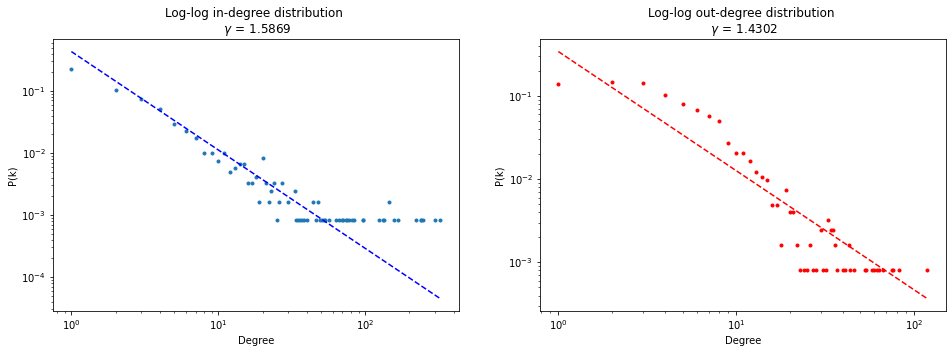

In [25]:
# plot for in_degree
plt.figure(figsize = [16, 5])
subax1 = plt.subplot(121)
plt.loglog(deg_in, np.array(list(cnt_in))/np.size(degree_sequence_in), '.') # the degree probability
fit = powerlaw.Fit(np.array(degree_sequence_in)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit pdf') # plotting the power law fit as a line
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.title('Log-log in-degree distribution \n $\gamma$ = '+ str(round(fit.power_law.alpha,4)))

# plot for out_degree
subax2 = plt.subplot(122)
plt.loglog(deg_out, np.array(list(cnt_out))/np.size(degree_sequence_out), '.r') # the degree probability
fit = powerlaw.Fit(np.array(degree_sequence_out)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'r',linestyle='--',label='fit pdf') # plotting the power law fit as a line
plt.title('Log-log out-degree distribution \n $\gamma$ = '+ str(round(fit.power_law.alpha,4)))
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.show()

For the network we get that the degree exponents are:
\begin{align}
\gamma_{in} &= 1.59 \\
\gamma_{out} &= 1.43
\end{align} 

Looking at figures directly above it seems power law is a good fit for the in- and out-degree distribution, meaning it's a scale free network.
  
For the network exponents $\gamma$ we see that they are quite low, which means the probability of high degree node $\langle k\rangle$ is exponentially high. This we can see from the power law given that $$P(k) = k^{-\gamma}$$

The fact that $\gamma_{in} < \gamma_{out}$ is very unusual. When comparing this to the [Network Science Book](http://networksciencebook.com/chapter/4#scale-free) section 4.4 it never hold true (except for email where it makes sence it's reversed). Importantly given that our graph is based on the [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) which follows the same format is Wikipedia, where $\gamma_{in} > \gamma_{out}$ [Wikipedia Network](https://arxiv.org/abs/physics/0602149) page 2, this property is highly unusual. Finally, looking at the degree counts for in/out-degree we see that there are nodes with much higher in-degree than out-degree. Thus the powerlaw fit must be a little off. Looking at the plot above, we also see that there seems to be a preference to the lower degree for the blue graph (in-degree) compared to the red graph (out-degree). Looking at the red graph (out-degree) this bias happens because there are a lot of nodes in the middle with higher probability which we see in the form of a little top. Compare this to the blue graph (in-degree) where the middle part much more closely follows our fit. 

Looking at the value of the exponents ($\gamma$) they also seem extreemly low when comparing to the wikipedia network in [Wikipedia Network](https://arxiv.org/abs/physics/0602149) page 2 (2.15,2.57), as it is on average 0.5 and 1 lower for $\gamma_{in}$ and $\gamma_{out}$ respectively. This results in an order of magnitude higher probability and high degree node in our network, even though nodes with much higher degree exist in the wikepedia network. This is due to the fact that our network is much smaller, meaning a much higher uncertainty. When taking the mean of the two network we've created: Zelda (From Assignment 2) and Star Wars (This project)
\begin{align}
\gamma_{in_{combine}} &= \frac{1.59 + 3.34}{2} = 2.47\\
\gamma_{out_{combine}} &= \frac{1.43 + 4.41}{2} = 2.92,
\end{align}
we see that it closely resembles the ones found for the [Wikipedia Network](https://arxiv.org/abs/physics/0602149) (2.15,2.57).

Looking at the [Wookieepedia](https://starwars.fandom.com/wiki/Main_Page) and thinking of it's real world properties, it would make sense that $\gamma_{in}>\gamma_{out}$ as many articles will reference main characters (like Luke Skywalker), but the article for Luke Skywalker won't reference all the characters back. This is also known as the 80/20 rule, which is also applicable to many other real world situations like a social network, Citation Network etc, where the few (20) are in control of the many (80).

For a final power law fit, we'll also look at the undirected graph and compare to a random graph (ER graph):

In [26]:
# Create the total undirected network 
SW_G_GCC = SW_DG_GCC.to_undirected().copy()

In [27]:
# Number of nodes
N = SW_DG_GCC.number_of_nodes() 

# Average degree 
k = [d for _, d in SW_DG_GCC.degree()] #list of degrees in the Zelda BotW network
k_mean = np.mean(k) # average degree

# probability 
p = k_mean/(N-1)

# Generate directed ER network of same size and p 
G_ER = nx.erdos_renyi_graph(n = N, p = p, directed =True)

In [28]:
#The distribution of degree for undirected
degree_sequence_undir_SW = sorted([d for _, d in SW_G_GCC.degree()])  # degree sequence
degreeCount_undir_SW = collections.Counter(degree_sequence_undir_SW)
deg_SW, cnt_SW = zip(*degreeCount_undir_SW.items())

#The distribution of degree for undirected random graph
G_ER_undir = nx.erdos_renyi_graph(n = N, p = p)
degree_sequence_undir_ER = sorted([d for _, d in G_ER_undir.degree()])  # degree sequence
degreeCount_undir_ER = collections.Counter(degree_sequence_undir_ER)
deg_ER, cnt_ER = zip(*degreeCount_undir_ER.items())

We can plot it and compare to our undiredted star wars graph, and do a power law fit.

No handles with labels found to put in legend.


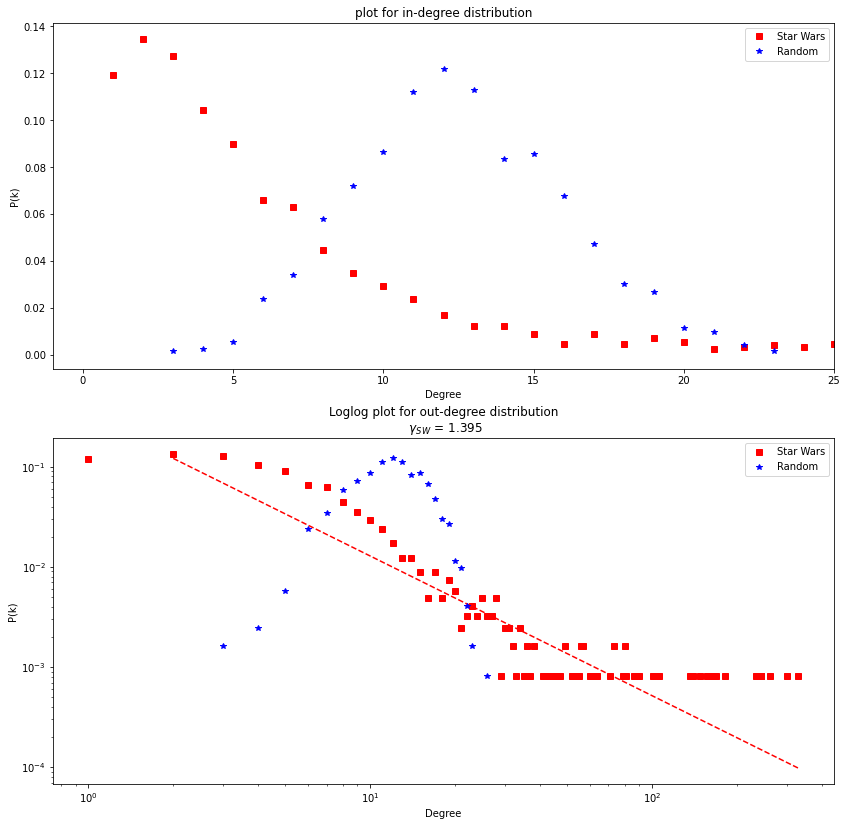

In [29]:
plt.figure(figsize = [14, 14])
subax1 = plt.subplot(211)
p1, = plt.plot(deg_SW, np.array(list(cnt_SW))/np.size(degree_sequence_undir_SW), 'sr') # degree probability of undirected SW graph
p2, = plt.plot(deg_ER, np.array(list(cnt_ER))/np.size(degree_sequence_undir_ER), '*b') # degree probability of undirected ER graph
plt.legend(loc="upper left")
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.xlim([-1,25])
plt.legend([p1, p2],["Star Wars", "Random"])
plt.title('plot for in-degree distribution')

subax2 = plt.subplot(212)
p1, = plt.loglog(deg_SW, np.array(list(cnt_SW))/np.size(degree_sequence_undir_SW), 'sr') # degree probability of undirected SW graph
fit = powerlaw.Fit(np.array(degree_sequence_undir_SW)+1, suppress_output=True, xmin = 1, discrete = True) # power law fit
fit.power_law.plot_pdf(color= 'r',linestyle='--',label='fit pdf') # plotting the power law fit as a line
p2, = plt.loglog(deg_ER, np.array(list(cnt_ER))/np.size(degree_sequence_undir_ER), '*b') # degree probability of undirected ER graph
plt.xlabel('Degree')
plt.ylabel('P(k)')
plt.legend([p1, p2],["Star Wars", "Random"])
plt.title('Loglog plot for out-degree distribution\n $\gamma_{SW}$ = '+ str(round(fit.power_law.alpha,4)))

plt.show()

From the plot above, it is clear that the ER graph does not follow a power law, but that the undirected Star Wars network does. We can also see that the random graph follows a typical poisson distribution. 

Finally, we see that with the combinatoion of high degree nodes from the in-degree distribution and the high probability of middle degree nodes from out-degree distribution, we get the power law fit with the lowest $\gamma = 1.40$, which is also too low when comparing to other network (exactly as we did for in/out-degree distribution). 

Looking at degree statistics for the ER graph:

In [30]:
# Degree distribution for in- and out-degree 
degree_sequence_in_ER = sorted([d for _, d in G_ER.in_degree()])  # degree sequence
degreeCount_in_ER = collections.Counter(degree_sequence_in_ER)
deg_in_ER, cnt_in_ER = zip(*degreeCount_in_ER.items())

degree_sequence_out_ER = sorted([d for _, d in G_ER.out_degree()])  # degree sequence
degreeCount_out_ER = collections.Counter(degree_sequence_out_ER)
deg_out_ER, cnt_out_ER = zip(*degreeCount_out_ER.items())

print('The maximum in-degree in the random network is ', max(degree_sequence_in_ER))
print('The minimum in-degree in the random network is ', min(degree_sequence_in_ER))

print('The maximum out-degree in the random network is ', max(degree_sequence_out_ER))
print('The minimum out-degree in the random network is ', min(degree_sequence_out_ER))

The maximum in-degree in the random network is  23
The minimum in-degree in the random network is  3
The maximum out-degree in the random network is  26
The minimum out-degree in the random network is  3


We also see that there are no nodes with high degree count exactly as expected, given that it does not posses the scale-free property.

# Community analysis

In [ ]:
md(f"The Louvain algorithm found {len(set(partition.values()))} communities for the botw network. The modularity is {community.modularity(partition, G_SW_GCC):.2f}.")

The Louvain algorithm found 18 communities for the botw network. The modularity is 0.48.

The community size is approx 14-19 (remember the partitions are a little random). To take a closer look at the communities we look a the distribution of community sizes.

We plot the distribution of community sizes.

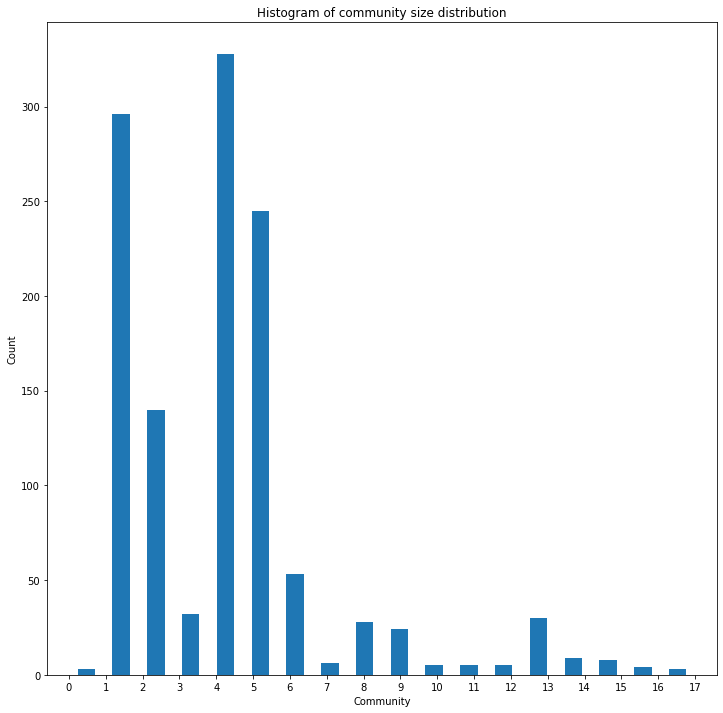

In [ ]:
plt.figure(figsize = [12, 12])
freq = plt.hist(partition.values(), bins = len(set(partition.values())), rwidth = 0.5)
community_size = pd.DataFrame(freq[0])
plt.xticks(range(len(set(partition.values()))))
plt.title('Histogram of community size distribution')
plt.xlabel('Community')
plt.ylabel('Count')
plt.show()

As we show in the plot for the network. The nodes with the main character for eac of the three trilogies are split into different communites, thus we will take closer look at these three comunities. 

In [ ]:
community_size.rename(columns = {0:'Community Size'}, inplace = True) #renaming column
com_trilogy = pd.DataFrame.from_dict({partition.get('Anakin_Skywalker'): [community_size.iloc[partition.get('Anakin_Skywalker'),0],'pre'], \
    partition.get('Luke_Skywalker'): [community_size.iloc[partition.get('Luke_Skywalker'),0],'or'],\
    partition.get('Rey_Skywalker'): [community_size.iloc[partition.get('Rey_Skywalker'),0],'seq']}, orient='index')
com_trilogy.rename(columns = {0:'Community Size', 1:'Trilogy'}, inplace = True)
com_trilogy

,Community Size,Trilogy
1,296.0,pre
5,245.0,or
4,328.0,seq


We create a dictionary with TF-IDF based rankings of words in each community

In [ ]:
com_dict = dict(zip(list(com_trilogy['Community Size'].keys()), [[key for key, val in partition.items() if val == com] for com in com_trilogy['Community Size'].keys()]))

Now we are saving the text from the APIs for all the names in the communities

In [ ]:
if not os.path.exists('data/Communities'):
    os.makedirs('data/Communities')

We create the corpus for the communities

In [ ]:
corpus_root_com = os.getcwd() + '/data/Communities/'
file_list_com = pd.Series([str(key) + '.txt' for key in com_dict.keys()])
corpus_com = pcr(corpus_root_com, file_list_com)

We filter names from dictionary to match with the actual text file names

In [ ]:
for com in com_dict.keys():
    for index in range(len(com_dict[com])):
        for j in characters_df["File_Name"][characters_df['Name'] == str(com_dict[com][index]).replace('_',' ')].tolist():
            com_dict[com][index] = j

We create corpus for community analysis

In [ ]:
for com in com_dict.keys():
    plus = pd.Series(com_dict[com]) + '.txt'
    text = nltk.Text(corpus.words(plus))

    temp_text = [w for w in text]
    temp_string = ' '.join(temp_text)
    
    file_path = corpus_root_com + str(com) + '.txt'
    with open(file_path, 'w', encoding = 'utf-8') as f:
        f.write(temp_string)

Define function that returns the top 5 words based on tf-idf

In [ ]:
def top_3_words(corpus):
    #Dictionary that includes the total number of words on each document
    sum_dict = {d:sum([val for _,val in FreqDist(corpus.words(d)).most_common()]) for d in corpus.fileids()}
    
    #Dictionary with values the term frequency for each word for each document
    tf_dict = {d:{term:(term_count/sum_dict[d]) for term,term_count in FreqDist(corpus.words(d)).most_common()} for d in corpus.fileids()}    
    
    #Dictionary with inverse document frequency for each unique words
    idf_dict = {}
    for term in set([term for i in tf_dict.keys() for term in tf_dict[i].keys()]):
        N = len(tf_dict.keys())
        nt = 0
        for d in tf_dict.keys():
            if term in tf_dict[d].keys():
                nt += 1
        idf_dict[term] = np.log(N/nt)
    
    #Create TF-IDF dictionary
    tf_idf_dict = {d:{term:tf_dict[d].get(term)*idf_dict.get(term) for term in tf_dict[d].keys()} for d in tf_dict.keys()}

    for community_index in tf_idf_dict.keys():
        top5 = [word for word,_ in sorted(tf_idf_dict[community_index].items(), key=lambda item: item[1],reverse=True)][:5]
        print(f"The 3 top words for the community no. {community_index.replace('.txt','')} are {top5}")

In [ ]:
top_3_words(corpus_com)

The 5 top words for the community no. 1 are ['cody', 'handmaiden', 'federation', 'clovis', 'ventress']
The 5 top words for the community no. 5 are ['rebo', 'pateesa', 'eisley', 'chainbreaker', 'treasury']
The 5 top words for the community no. 4 are ['doza', 'ryvora', 'torra', 'yeager', 'synara']


From the list of most descriptive words we can identity as the first community associated with evil and the dark side the second community associated with jedis and the light side and the third community with the resistant fighter such as [Jyn Erso](https://starwars.fandom.com/wiki/Jyn_Erso) the daughter of the builder of Death Star and [Wedge Antilles](https://starwars.fandom.com/wiki/Wedge_Antilles) a known tie fighter pilot amongst the resistance.